In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from SHUtil import SHCilmToVector, lmk2K, K2lmk

In [2]:
p = 1
a = 1
mu = 1
nu = 1./3

#### traction mode matrix info ####
lJmax = 5 # max l degree for saving a single mode
lKmax = 3 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
## DH2 mesh
#Ngrid = 100
#theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
#phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)
## GLQ mesh
latglq, longlq = pyshtools.expand.GLQGridCoord(lJmax)
theta = np.deg2rad(90 - latglq)
phi = np.deg2rad(longlq)

THETA,PHI = np.meshgrid(theta, phi)
R = np.ones_like(THETA)
X, Y, Z = SphCoord_to_CartCoord(R, THETA, PHI)
N = -np.stack((X/R, Y/R, Z/R), axis=-1)

In [3]:
#### generate boundary condition ####
S_inf = np.zeros(X.shape+(3, 3))
S_inf[...,0,0] = p
S_inf[...,1,1] = p
S_inf[...,2,2] = p

#T_inf = np.sum(S_inf*N[...,np.newaxis,:],axis=-1)
T_inf = np.einsum('ijkl,ijl->ijk', S_inf, N)
T_usr_mesh = T_inf.astype(np.complex)
T_usr_vec = np.empty(3*LJ, dtype=np.complex)
for k in range(3):
    T_usr_grid = pyshtools.SHGrid.from_array(T_usr_mesh[...,k].T, grid='GLQ')
    #T_usr_grid.plot()#3d(elevation=20, azimuth=45)
    T_usr_cilm = T_usr_grid.expand()
    T_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)

In [4]:
#### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from ShElastic import calSmode
from SHBV import generate_submat, visualize_Cmat
import time
ticT = time.time()
shtype = 'irr'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
tocT = time.time()
print(tocT-ticT)

0.0682990550994873


In [5]:
from SHBV import print_SH_mode

ticA = time.time()
A = spm.linalg.lsqr(Cmat, T_usr_vec.transpose())
tocA = time.time()
print('Residual:', A[3], 'Time:', tocA-ticA)
A_sol = np.zeros_like(A[0])
A_sol[np.abs(A[0]) > 1e-8] = A[0][np.abs(A[0]) > 1e-8]
print('Solution:', A_sol.size)
#index_sol = print_SH_mode(A_sol, m_dir=3)

Residual: 3.39716002458189e-15 Time: 0.008695602416992188
Solution: 48


In [6]:
from SHBV import fast_stress_solution

x_grid = np.linspace(1.01, 4.5)
Y, X, Z = np.meshgrid(x_grid, [0, ], [0, ])

R,THETA,PHI = CartCoord_to_SphCoord(X, Y, Z)

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(1, 50, 1, 3, 3) 0.013112783432006836


(30, 2) (19, 2)


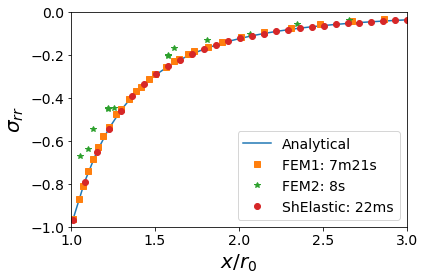

In [7]:
# FEM result
FEM_1 = loadmat('../testdata/uniform_pressure_case_1.mat')['M'][2::4,:]
FEM_2 = loadmat('../testdata/uniform_pressure_case_2.mat')['M']
#FEM = loadmat('../testdata/tensile_hole1.mat')['M'][::16, :]

print(FEM_1.shape, FEM_2.shape)#, FEM.shape)

C = -p * a**3
D = 0
srr = C/R**3 + D

plt.plot(x_grid, srr.flatten(), label='Analytical')
plt.plot(FEM_1[:, 0],-FEM_1[:, 1], 's', label='FEM1: 7m21s')
plt.plot(FEM_2[:, 0],-FEM_2[:, 1], '*',  label='FEM2: 8s')
total_time = 1000*(toc-tic+tocA-ticA)
plt.plot(x_grid, sigma_tot[...,1,1].flatten(), 'o', label='ShElastic: %.0fms' % total_time)
plt.xlim(1, 3)
plt.ylim(-1, 0)
plt.tick_params(labelsize=14)
plt.xlabel(r'$x/r_0$', fontsize=20)
plt.ylabel(r'$\sigma_{rr}$', fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('../figures/case1-result.png', dpi=1000, transparent=True)
plt.show()